# Explore K-Radar Data

First we have to define the path to the dataset and the configuration file used to load the data.

In [1]:
from dprt.utils.config import load_config

# Define data path
src = '/data/kradar/raw'
cfg = '/app/config/kradar.json'

# Load dataset configuration
config = load_config(cfg)

#### Load the data
In a seceond step we have to load the data for the raw dataset files to make it accesable to our subsequent tasks.

In [2]:
from dprt.datasets import prepare

# Create preperator instance
preperator = prepare(config['dataset'], config)

# Get single dataset sample
dataset_paths = preperator.get_dataset_paths(src)
sequence_paths = preperator.get_sequence_paths(next(iter(dataset_paths['train'].values())))
sample = next(iter(sequence_paths.values()))

#### Visualize the data
Now we are ready to explore the data and visualize it to get a first impression of what we a working with. Therefore, we are first importing the visualization package.

*When you are working within a docker, please don't forget to enable xhost access:* `sudo xhost +local:docker`

In [3]:
from dprt.utils import visu

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


To get an image of the current scene, we will first visualize the data of one of the front cameras.

/app/src/dprt/utils/visu.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


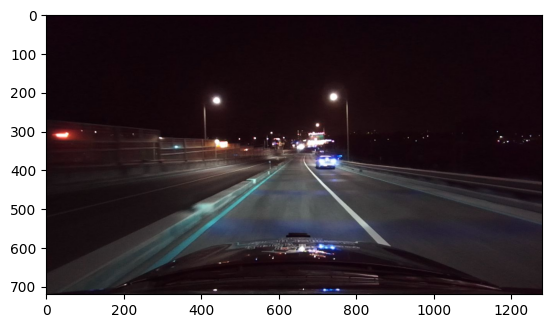

In [4]:
# Load front camera data
camera_front, _ = preperator.get_camera_data(sample['camera_front'])

# Visualize camera data
visu.visu_camera_data(camera_front)

To get an better understanding of the three dimensional objects and structures, we can also have a look at the associated lidar data as well as the annotated objects.

In [5]:
# Load lidar data
point_cloud = preperator.get_lidar_data(sample['os2'])

# Load bounding boxes
boxes = preperator.get_boxes(sample['label'])

# Visualize lidar data
visu.visu_lidar_data(point_cloud, boxes, xlim=[-100, 100], ylim=[-100, 100])

Next, we will have a look at the radar data of the K-Radar dataset. To do so, we will first have to load the raw data of the 4D radar tesseract.

In [6]:
# Load radar tesseract with shape (doppler, range, elevation, azimuth)
tesseract = preperator.get_radar_tesseract(sample['radar_tesseract'])

However, to associate the cells of the tesseract with physical values, we have to load the rasterization of the radar sensor.

In [7]:
from dprt.datasets.kradar.utils import radar_info

# Rasterization of the 
raster = {
    'a': radar_info.azimuth_raster,
    'd': radar_info.doppler_raster,
    'e': radar_info.elevation_raster,
    'r': radar_info.range_raster,
}

Since it is hard to visualize a 4D radar tesseract, we will work with different projections of the data to get an impression of the raw data. The first projection is a 3D representation of the range, azimuth and elevaion dimension, where the colors represent the radar cross section (rcs) or reflectivity. This view can be very helpfull to get an first impression of the data.

In [8]:
# Visualize 3D radar cube
visu.visu_radar_tesseract(tesseract, dims='rae', raster=raster, cart=True)

The first projection we are looking at is the range-azimuth plane, which corresponds to the bird's-eye view (BEV) of the scene.

/app/src/dprt/utils/visu.py:470: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


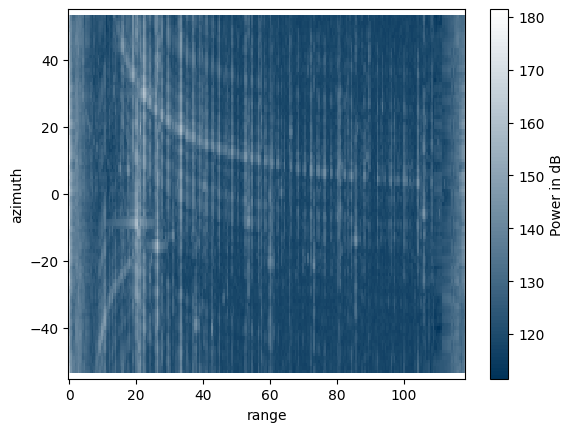

In [9]:
# Visualize the RA data
visu.visu_radar_tesseract(tesseract, dims='ra', raster=raster)

Unfortunatly, we are not used to work with data in polar coordinates, which is why this figure might be hard to interprete. Apart from that, the ground truth annotations are made in cartesian coordinates, which is why it might be benificial to visualize the data in cartesian coordinates. This can be easyly done by setting the cart argument to true.

/app/src/dprt/utils/visu.py:376: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p = ax.pcolormesh(x_mesh, y_mesh, rcs.T, cmap=cm, shading='nearest')


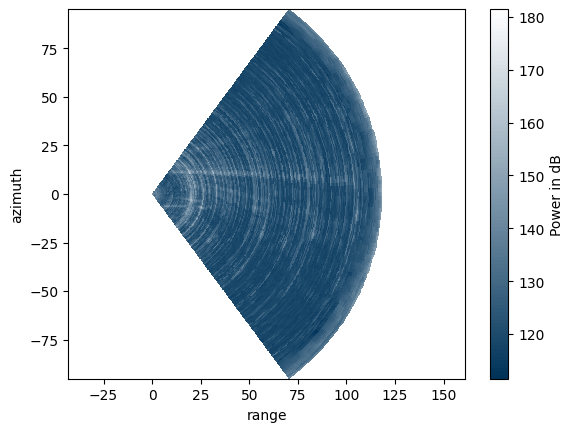

In [10]:
# Visualize the RA data in cartesian coordinates
visu.visu_radar_tesseract(tesseract, dims='ra', raster=raster, cart=True)

Finally, we can put everything together and visualize the radar data with the associated lidar data and object annotations. This gives us a very good understanding of the radar features associated with specific objects and structures. However, to do so we have to transform all data sources to the same coordinate frame. Therefore, we have to load the sensor calibration information, create a transformation matrix and transform the bounding boxes and lidar points.

/app/src/dprt/utils/visu.py:376: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p = ax.pcolormesh(x_mesh, y_mesh, rcs.T, cmap=cm, shading='nearest')
/app/src/dprt/utils/visu.py:470: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


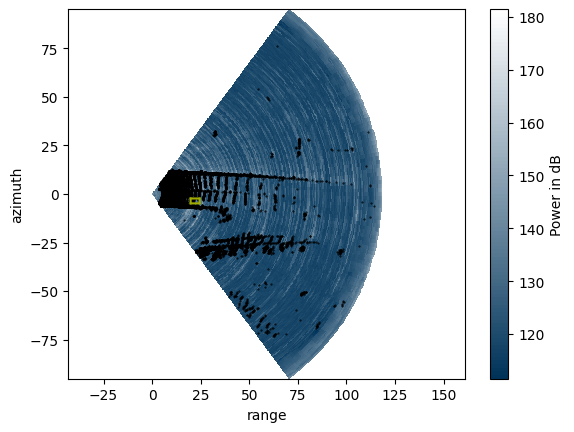

In [14]:
from dprt.utils.geometry import transform_boxes, transform_points

# Get calibration information
tm = preperator.get_translation(sample['calib_radar_lidar'])

# Transform boxes and points
boxes = transform_boxes(boxes, tm)
points = transform_points(point_cloud, tm)

# Visualize radar data
visu.visu_radar_tesseract(tesseract, dims='ra', raster=raster, boxes=boxes, points=points, roi=True, cart=True)